In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
from collections import defaultdict

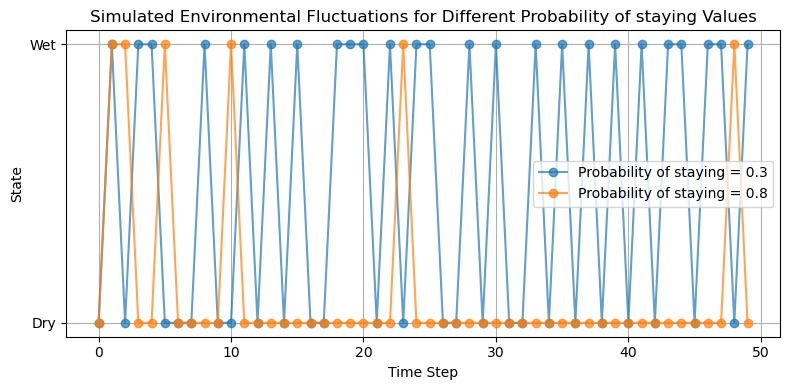

In [2]:

# Parameters
e_values = [0.3, 0.8]         # Two different 'staying' probabilities
n_gen = 50                   # Number of generations/time steps
states = ['Dry', 'Wet']
n_states = len(states)

# Initialize the figure
plt.figure(figsize=(8, 4))

for idx, e in enumerate(e_values):
    env_sequence = []
    current_state = 0  # Start at Dry

    # Transition probability matrix
    Transition_probs = np.array([
        [e, 1-e],  # From Dry
        [1-e, e]   # From Wet
    ])

    # Simulate the environment sequence
    for _ in range(n_gen):
        env_sequence.append(current_state)
        current_state = np.random.choice([0, 1], p=Transition_probs[current_state])

    # Plot
    plt.plot(env_sequence, marker='o', linestyle='-', label=f'Probability of staying = {e}', alpha=0.7)

# Final plot settings
plt.title("Simulated Environmental Fluctuations for Different Probability of staying Values")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.yticks([0, 1], states)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Defining functions

In [3]:
def w(z_combined):
    return (np.exp(-z_combined**2 /(2))) 

def z_dist(z1, env_opt):
    x0 = env_opt
    return ((np.sqrt((x0 - z1)**2 )))

### Setting some constants

##### Population size

In [ ]:
population_size =1000

##### Mutation rates and sizes

In [15]:

## mutation rates
mu_g= 1e-06
mu_e= 1e-03

sigma_mut=0.8
sigma_epimut=0.3
sigma_d=0.7
sigma_epsilon= 0.05
#no. of generations

n_gen = 5000


##### Weights

In [32]:

##starting values of weights

alpha= np.random.uniform(low=0, high=1, size=population_size) 
beta = np.random.uniform(low=0, high=1, size=population_size) 
gamma = np.random.uniform(low=0, high=1, size=population_size) 
beta= np.random.uniform(low=0, high=1, size=population_size) 

##FOR NOW WE SET MATERNAL WEIGHT AND TRAIT TO 0
#gamma= np.random.uniform(low=0, high=1, size=population_size) 

m0_a = 0.01


##### Enviornmnetal constants

In [29]:
states = ["Dry", "Wet"]
n_states = len(states)

# Simulate environment over time
n_gen = 1000
env_sequence = []
current_state = 0 

Env = np.array([
    [-0.9],  
    [0.2],  
 ])

e= 0.6 # tPro of 'staying'

# Transition probability matrix
Transition_probs = np.array([
        [e, 1-e],  # From Dry
        [1-e, e]   # From Wet
    ])

###### Probability of staying

In [17]:
#Range of Probabilities of staying to be explored

prob_staying = np.round(np.arange(0.01, 1.01, 0.11), 2)
print(prob_staying)



[0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]


##### Stating values of phenotyopes

In [16]:
z_a_t= np.random.uniform(low=-100, high=100, size=population_size) 
y_a_t = np.random.uniform(low=-0.5, high=0.5, size=population_size)


#### Simulation

In [18]:

# Empty lists for record keeping

mean_A_over_time = []
mean_B_over_time = []
mean_fitness_over_time = []
mean_fitness_at_0_75 = []
time_to_fitness_0_75 = pd.DataFrame(columns=['alpha', 'time'])
phenotype_over_time = []
var_fitness_over_time= []
optimum_A_over_time = []
optimum_B_over_time = []
population_size = 1000

mean_alpha =[]
mean_beta= []
mean_gamma= []

results =  pd.DataFrame(columns=['prob_staying','alpha_mean','alpha_var','beta_mean','beta_var','gamma_mean','gamma_var'])

for e in prob_staying:
    # Transition probability matrix
    Transition_probs = np.array([
        [e, 1 - e],  # From Dry
        [1 - e, e]   # From Wet
    ])
    z_a_t= np.random.uniform(low=-100, high=100, size=population_size) 
    y_a_t = np.random.uniform(low=-0.5, high=0.5, size=population_size)

    alpha= np.random.uniform(low=0, high=1, size=population_size) 
    beta = np.random.uniform(low=0, high=1, size=population_size) 
    gamma = np.random.uniform(low=0, high=1, size=population_size) 
        
    for _ in range(n_gen): 
        # Initialize variables for the simulation
        current_state = 0  # start dry
        gen = 0
        keep_going = True
              
        # Choose the current environment
        env_sequence.append(states[current_state])  # Start at "Dry"
        current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
        # Optimum stats
        A0 = Env[current_state]
        optimum_A_over_time.append(A0)
            
        # Sample variances
        epsilon_Z = np.random.normal(0, sigma_mut, size=population_size)
        epsilon_Y = np.random.normal(0, sigma_epimut, size=population_size)
        epsilon_t = np.random.normal(0, sigma_epsilon, size=population_size)
        d_t = np.random.normal(0, sigma_d, size=population_size)
            
        # Trait A
        z_a_t_plus_1 = z_a_t + mu_g * epsilon_Z
        y_a_t_plus_1 = y_a_t + mu_e * epsilon_Y
            
        # Maternal effects from -1 generation
        m1_a = (A0 - (z_a_t + y_a_t))
        mt_a = (m0_a + m1_a + epsilon_t)
            
        # Full phenotype
        P_a = alpha * z_a_t_plus_1 + beta * y_a_t_plus_1 + gamma * mt_a + d_t
            
                        
        mean_A_over_time.append(P_a.mean())
            
        P_com = z_dist(P_a, Env[current_state])
        fitness = w(P_com)
        relative_fitness = fitness / P_com.mean()
        phenotype_over_time.append(P_com.mean())
            
        # Save results
        new_row = pd.DataFrame({'prob_staying': [e],
                                'alpha_mean': alpha.mean(),
                                'alpha_var': alpha.var(),
                                'beta_mean': beta.mean(),
                                'beta_var': beta.var(),
                                'gamma_mean': gamma.mean(),
                                'gamma_var': gamma.var()})
        
        results = pd.concat([results, new_row], ignore_index=True)
            
        # Create a dataframe of individual data
        df = pd.DataFrame({'A_g': z_a_t_plus_1,
                                'A_e': y_a_t_plus_1,
                                'alpha': alpha,
                                'beta': beta,
                                'gamma': gamma,
                                'Mat_a': mt_a,
                                'Phenotype': P_com,
                                'fitness': fitness,
                                'relative_fitness': relative_fitness})
            
        mean_fitness_over_time.append(df['fitness'].mean())
        var_fitness_over_time.append(df['fitness'].var())
            
        # Resample for next generation
        sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)
        z_a_t = sampled_df['A_g'].values
        y_a_t = sampled_df['A_e'].values 
        alpha = sampled_df['alpha'].values
        beta = sampled_df['beta'].values
        gamma = sampled_df['gamma'].values
       # print('alpha',alpha)



/tmp/ipykernel_47292/3200930069.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


In [4]:
print(results.head())
results_grouped = results.groupby('prob_staying')

NameError: name 'results' is not defined

<Figure size 1000x600 with 0 Axes>

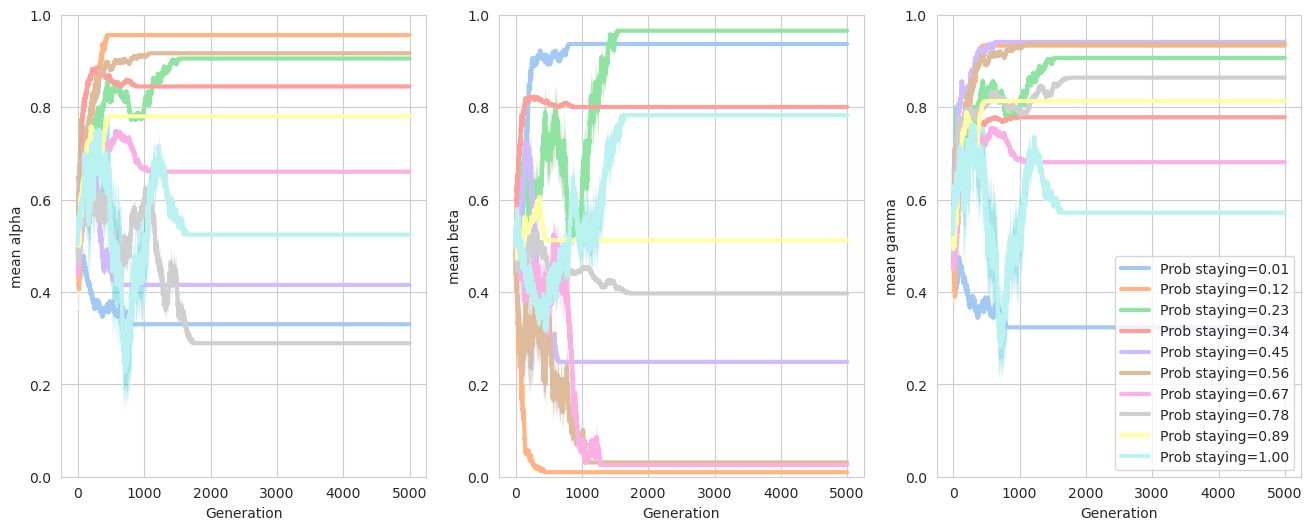

In [22]:
generations = np.linspace(1,n_gen, n_gen)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
qual_palette = sns.color_palette("pastel", len(results_grouped))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

for i, (prob_stay, group) in enumerate(results_grouped):
    #print(len(group['alpha_mean']))
    y=group['alpha_mean']
    error= group['alpha_var']
    ax1.plot(generations, y, label= f'Prob staying={prob_stay:.2f}',linewidth=3, 
             color=qual_palette[i])  # Use the color from the palette
    ax1.fill_between(generations, y-error, y+error,alpha=0.4)

ax1.set_xlabel('Generation')
ax1.set_ylabel('mean alpha')
ax1.set_ylim(0,1)
ax1.grid(True)
ax1.legend('', frameon=False)



for i, (prob_stay, group) in enumerate(results_grouped):
    #print(len(group['alpha_mean']))
    y=group['beta_mean']
    error= group['beta_var']
    ax2.plot(generations, y, label= f'Prob staying={prob_stay:.2f}',linewidth=3, 
             color=qual_palette[i])  # Use the color from the palette
    ax2.fill_between(generations, y-error, y+error,alpha=0.4)
    
ax2.set_xlabel('Generation')
ax2.set_ylabel('mean beta')
ax2.set_ylim(0,1)
ax2.grid(True)
ax2.legend('', frameon=False)




for i, (prob_stay, group) in enumerate(results_grouped):
    #print(len(group['alpha_mean']))
    y=group['gamma_mean']
    error= group['gamma_var']
    ax3.plot(generations, y, label= f'Prob staying={prob_stay:.2f}',linewidth=3, 
             color=qual_palette[i])  # Use the color from the palette
    ax3.fill_between(generations, y-error, y+error,alpha=0.4)
    
ax3.set_xlabel('Generation')
ax3.set_ylabel('mean gamma')
ax3.set_ylim(0,1)
ax3.grid(True)
ax3.legend()